# Análise de Perfil de Vento com Transformadas Wavelet

Este notebook apresenta uma análise do perfil de vento utilizando técnicas de processamento de sinais baseadas em transformadas wavelet para redução de ruído e extração de características. O objetivo é identificar as variáveis mais relevantes para prever a velocidade do vento a 100m de altura.

## 1. Importação de Bibliotecas

Bibliotecas utilizadas para análise de séries temporais, processamento de sinais wavelet, visualização de dados e modelagem preditiva.

In [16]:
# Importação das bibliotecas necessárias para análise
import pandas as pd
import numpy as np
import pywt  # Biblioteca para transformações wavelet
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import acf, pacf  # Funções para autocorrelação
from sklearn.metrics import mutual_info_score  # Para cálculo de informação mútua
from statsmodels.tsa.seasonal import seasonal_decompose  # Para decomposição de séries temporais

## 2. Definição de Funções

Funções auxiliares para processamento de sinais, denoising wavelet, análise de séries temporais e engenharia de features.

In [17]:
# Definição das funções de pré-processamento e engenharia de features

# Função de denoising com wavelet
# Esta função aplica técnicas de wavelet para redução de ruído em sinais
def wavelet_denoising(signal, wavelet='sym18', level=2):
    """
    Aplica técnica de denoising wavelet para reduzir o ruído do sinal
    
    Parâmetros:
    signal: array-like - O sinal de entrada a ser processado
    wavelet: str - O tipo de wavelet a ser utilizado (default: 'sym18')
    level: int - O nível de decomposição wavelet (default: 2)
    
    Retorna:
    array-like - Sinal reconstruído após a remoção de ruído
    """
    # Decomposição do sinal usando wavelet
    coeffs = pywt.wavedec(signal, wavelet, mode='periodization', level=level)
    
    # Cálculo do threshold usando o método de Donoho
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    
    # Aplicação do threshold (soft thresholding)
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    
    # Reconstrução do sinal
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='periodization')
    return reconstructed_signal[:len(signal)]

# Função para encontrar a melhor janela de previsão baseada na função de autocorrelação (ACF)
def best_prediction_window(signal, max_lag=288):
    """
    Identifica as melhores janelas de previsão baseadas no ACF
    
    Parâmetros:
    signal: array-like - O sinal de entrada
    max_lag: int - O número máximo de lags a considerar (default: 288)
    
    Retorna:
    tuple - (índices dos cruzamentos com o threshold, valores de ACF)
    """
    # Limita o lag máximo ao tamanho do sinal
    max_lag = min(len(signal) - 1, max_lag)
    
    # Calcula a autocorrelação
    acf_values = acf(signal, nlags=max_lag, fft=False)
    
    # Define o threshold como 1/e (≈0.368)
    threshold = 1 / np.e
    
    # Encontra os pontos de cruzamento do threshold
    diffs = acf_values - threshold
    crossings = np.where((diffs[:-1] > 0) & (diffs[1:] <= 0))[0]
    
    return crossings, acf_values

# Função para calcular a Average Mutual Information (AMI)
def calculate_ami(x, y, bins=20):
    """
    Calcula a informação mútua entre duas séries temporais
    
    Parâmetros:
    x, y: array-like - Os sinais para cálculo da informação mútua
    bins: int - Número de bins para histograma (default: 20)
    
    Retorna:
    float - O valor da informação mútua
    """
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Função para encontrar todos os mínimos locais na curva de AMI
def find_all_minimums_ami(ami_values):
    """
    Identifica todos os mínimos locais na curva de AMI
    
    Parâmetros:
    ami_values: array-like - Os valores de AMI calculados
    
    Retorna:
    list - Índices dos mínimos locais
    """
    minima = []
    for i in range(1, len(ami_values)-1):
        if ami_values[i] < ami_values[i-1] and ami_values[i] < ami_values[i+1]:
            minima.append(i+1)  # +1 para ajustar o índice devido ao lag iniciar em 1
    return minima

# Função para determinar os lags usando AMI
def select_lags_ami(signal, max_lag=288, bins=20):
    """
    Seleciona lags significativos usando a técnica de Average Mutual Information
    
    Parâmetros:
    signal: array-like - O sinal de entrada
    max_lag: int - O número máximo de lags a considerar (default: 288)
    bins: int - Número de bins para histograma (default: 20)
    
    Retorna:
    tuple - (mínimos locais, máximos locais, valores de AMI)
    """
    ami_values = [calculate_ami(signal[:-lag], signal[lag:]) for lag in range(1, max_lag+1)]
    minima = find_all_minimums_ami(ami_values)
    maxima = []  # Inicialização para evitar erro, caso seja necessária
    return minima, maxima, ami_values

# Função para criar features de rolling
def create_rolling_features(df, windows):
    """
    Cria características de média móvel para diferentes tamanhos de janela
    
    Parâmetros:
    df: DataFrame - DataFrame com as séries temporais
    windows: dict - Dicionário com nomes e tamanhos das janelas
    
    Retorna:
    DataFrame - DataFrame com as novas características de média móvel
    """
    df_rolled = pd.DataFrame(index=df.index)
    for window_name, window_size in windows.items():
        for col in df.columns:
            df_rolled[f'{col}_rolling_mean_{window_name}'] = df[col].rolling(window=window_size, min_periods=1).mean()
    return df_rolled

In [18]:
# Carregamento e preparação inicial dos dados

# Leitura do arquivo de dados
data = pd.read_csv('../data/dataset.csv')

# Processamento da coluna de data/hora para criar um índice de série temporal
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0])
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce')
data.set_index('id_datetime', inplace=True)
data.drop(columns=['id_str'], inplace=True)

# Criação de um DataFrame vazio para armazenar as variáveis processadas
variables = pd.DataFrame(index=data.index)

## 3. Carregamento e Preparação dos Dados

Importação do conjunto de dados, tratamento das colunas de data/hora e estruturação do DataFrame para análise.

Correlação das variáveis com 'ws100':
year                NaN
month         -0.209302
day           -0.099138
hour           0.027247
minute        -0.009205
                 ...   
vertdisp190    0.265527
vertdisp200    0.258682
vertdisp220    0.246761
vertdisp240    0.237659
vertdisp260    0.228765
Name: ws100, Length: 107, dtype: float64

Correlações filtradas (|correlação| > 1/e):
humid        -0.433935
wdisp40       0.671055
wdisp50       0.654558
wdisp60       0.635030
wdisp70       0.614828
wdisp80       0.595994
wdisp90       0.577574
wdisp100      0.558741
wdisp110      0.539850
wdisp120      0.521773
wdisp130      0.502699
wdisp140      0.483278
wdisp150      0.465046
wdisp160      0.448319
wdisp170      0.432731
wdisp180      0.416633
wdisp190      0.400466
wdisp200      0.385741
vertdisp40    0.491436
vertdisp50    0.477266
vertdisp60    0.447528
vertdisp70    0.422799
vertdisp80    0.400473
vertdisp90    0.382295
Name: ws100, dtype: float64


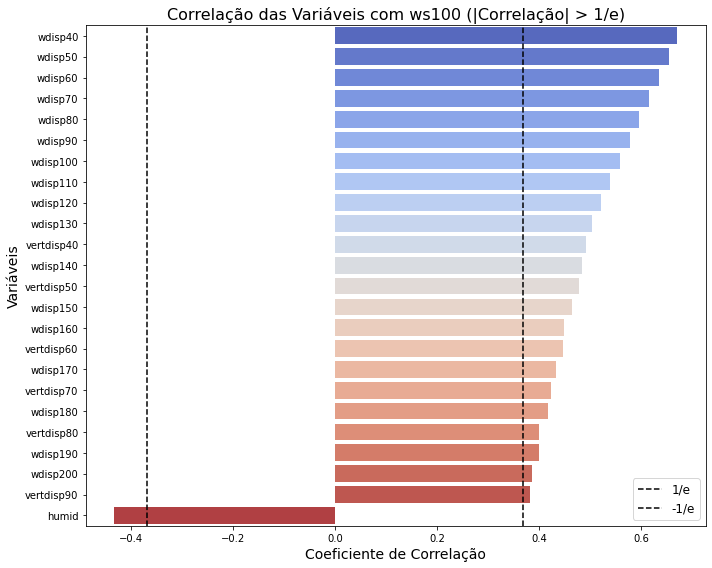

In [19]:
# Análise exploratória inicial: correlação das variáveis numéricas com ws100

# Seleciona apenas as colunas numéricas do DataFrame
dados_numericos = data.select_dtypes(include=['number'])

# Verifica se a coluna alvo 'ws100' está presente no conjunto de dados
if 'ws100' not in dados_numericos.columns:
    raise ValueError("A coluna 'ws100' não foi encontrada nas colunas numéricas do DataFrame.")

# Identifica colunas relacionadas à velocidade do vento (ws)
ws_columns = dados_numericos.filter(like='ws').columns

# Calcula a correlação de todas as variáveis com 'ws100'
# Exclui as colunas de velocidade para evitar autocorrelação
correlacoes_ws100 = dados_numericos.corr()['ws100'].drop(ws_columns)
print("Correlação das variáveis com 'ws100':")
print(correlacoes_ws100)

# Definição do limiar significativo como 1/e (≈0.368)
um_sobre_e = 1 / np.e  # Aproximadamente 0.36787944117

# Filtra as correlações que são consideradas significativas (> 1/e ou < -1/e)
correlacoes_filtradas = correlacoes_ws100[
    (correlacoes_ws100 > um_sobre_e) | (correlacoes_ws100 < -um_sobre_e)
]
print("\nCorrelações filtradas (|correlação| > 1/e):")
print(correlacoes_filtradas)

# Verifica se há variáveis que atendem ao critério e gera visualização
if correlacoes_filtradas.empty:
    print("\nNenhuma variável possui correlação com 'ws100' maior que 1/e ou menor que -1/e.")
else:
    # Configuração do gráfico de barras para visualização de correlações significativas
    plt.figure(figsize=(10, 8))
    
    # Ordena as correlações para melhor visualização
    correlacoes_ordenadas = correlacoes_filtradas.sort_values(ascending=False)
    
    # Criação do gráfico de barras com as correlações significativas
    sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm')
    
    # Adiciona títulos e rótulos
    plt.title('Correlação das Variáveis com ws100 (|Correlação| > 1/e)', fontsize=16)
    plt.xlabel('Coeficiente de Correlação', fontsize=14)
    plt.ylabel('Variáveis', fontsize=14)
    
    # Adiciona linhas para marcar os limiares de significância
    plt.axvline(x=um_sobre_e, color='black', linestyle='--', label='1/e')
    plt.axvline(x=-um_sobre_e, color='black', linestyle='--', label='-1/e')
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

## 4. Análise Exploratória Inicial

Cálculo de correlações entre variáveis numéricas e a velocidade do vento a 100m (variável alvo) para identificação de potenciais preditores.

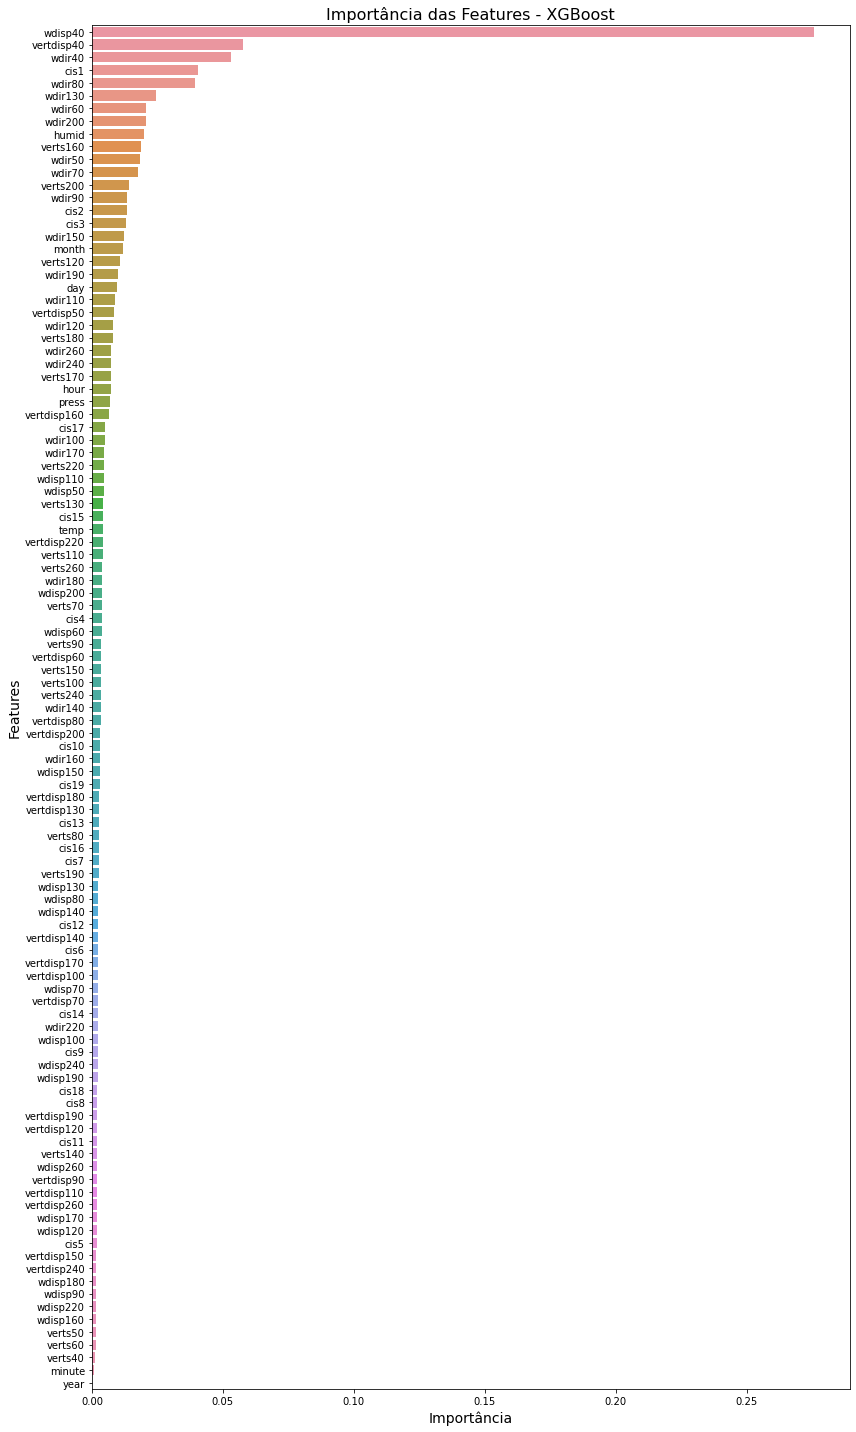

In [20]:
# Análise de importância de features usando XGBoost

from sklearn.model_selection import train_test_split
import xgboost as xgb

# Preparação dos dados para modelagem
ws_columns = dados_numericos.filter(like='ws').columns
X = dados_numericos.drop(columns=ws_columns, axis=1)  # Features
y = dados_numericos['ws100']  # Variável alvo

# Divisão dos dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

features = X.columns

# Inicialização e treinamento do modelo XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgbr.fit(X_train, y_train)

# Extração da importância das features do modelo
importancias_xgb = xgbr.feature_importances_
df_importancias_xgb = pd.DataFrame({'Feature': features, 'Importância': importancias_xgb})
df_importancias_xgb = df_importancias_xgb.sort_values(by='Importância', ascending=False)

# Visualização gráfica da importância das features
plt.figure(figsize=(12, 20))
sns.barplot(x='Importância', y='Feature', data=df_importancias_xgb)
plt.title('Importância das Features - XGBoost', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Análise de Importância de Features

Avaliação da importância das variáveis preditoras utilizando o algoritmo XGBoost, que permite identificar as features mais relevantes para a previsão da velocidade do vento.

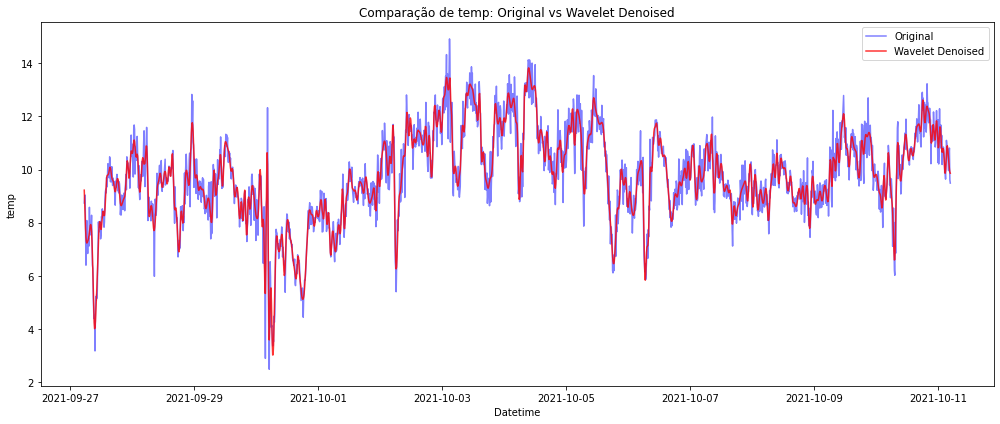

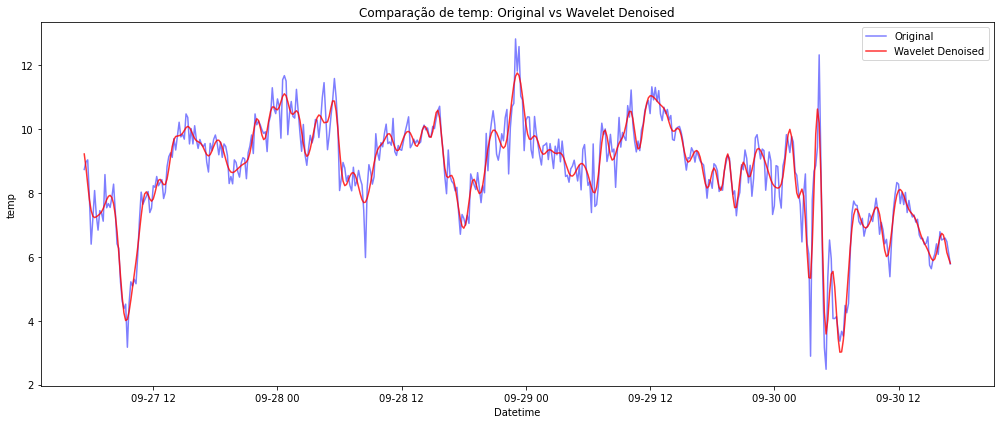

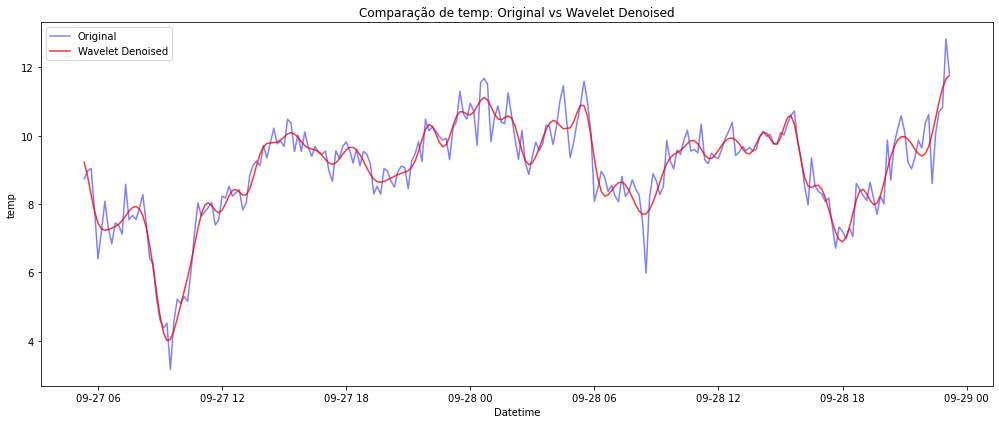

In [21]:
# Aplicação de denoising wavelet às variáveis selecionadas

# Lista das colunas que serão submetidas ao processo de denoising
columns_to_denoise = ['ws100', 'wdisp40', 'vertdisp40', 'wdir40', 'cis1', 'humid', 'temp']

# Aplica o denoising em cada coluna e armazena os resultados
for col in columns_to_denoise:
    if col in data.columns:
        # Aplica a função de denoising wavelet
        denoised_signal = wavelet_denoising(data[col].values)
        # Armazena o sinal processado no DataFrame de variáveis
        variables[f'{col}_wavelet'] = denoised_signal
    else:
        raise ValueError(f"A coluna '{col}' não existe no conjunto de dados.")
    
# Visualização comparativa entre o sinal original e o sinal após denoising
# Intervalo longo (2000 pontos)
plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:3500], data['ws100'][1500:3500], label='Original', alpha=0.5, color='blue')
plt.plot(variables.index[1500:3500], variables['ws100_wavelet'][1500:3500], label='Wavelet Denoised', alpha=0.8, color='red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()

# Intervalo médio (500 pontos)
plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:2000], data['ws100'][1500:2000], label='Original', alpha=0.5, color='blue')
plt.plot(variables.index[1500:2000], variables['ws100_wavelet'][1500:2000], label='Wavelet Denoised', alpha=0.8, color='red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()

# Intervalo curto (250 pontos) - permite visualizar detalhes
plt.figure(figsize=(14, 6))
plt.plot(data.index[1500:1750], data['ws100'][1500:1750], label='Original', alpha=0.5, color='blue')
plt.plot(variables.index[1500:1750], variables['ws100_wavelet'][1500:1750], label='Wavelet Denoised', alpha=0.8, color='red')
plt.title(f'Comparação de {col}: Original vs Wavelet Denoised')
plt.xlabel('Datetime')
plt.ylabel(col)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Aplicação de Transformadas Wavelet

Processamento de sinais utilizando transformadas wavelet para redução de ruído nas variáveis selecionadas. Comparação visual entre sinais originais e processados.

In [22]:
# Criação de features baseadas em médias móveis

# Define a função para criar características de média móvel
def create_rolling_features(df, windows):
    """
    Cria características de média móvel para diferentes tamanhos de janela
    
    Parâmetros:
    df: DataFrame - DataFrame com as séries temporais
    windows: dict - Dicionário com nomes e tamanhos das janelas
    
    Retorna:
    DataFrame - DataFrame com as novas características de média móvel
    """
    df_rolled = pd.DataFrame(index=df.index)
    for window_name, window_size in windows.items():
        for col in df.columns:
            df_rolled[f'{col}_rolling_mean_{window_name}'] = df[col].rolling(window=window_size, min_periods=1).mean()
    return df_rolled

# Define o tamanho da janela: diária (144 observações, assumindo medições a cada 10 minutos)
windows = {
    'daily': 144
}

# Aplica a criação de features de média móvel
rolling_features = create_rolling_features(variables, windows)

## 7. Criação de Features Baseadas em Médias Móveis

Geração de características derivadas utilizando técnicas de médias móveis para capturar tendências temporais nos dados.

In [23]:
# Análise de lags significativos usando Average Mutual Information (AMI)

# Aplicação da técnica de AMI para cada variável processada
lags_selected = {}
for col in variables.columns:
    signal = variables[col].dropna()
    # Calcula os mínimos na curva AMI, que são candidatos a lags significativos
    minima, maxima, ami_values = select_lags_ami(signal, max_lag=288, bins=20)
    print(f"Mínima: Lag selecionado usando AMI para {col}: {minima}")

Mínima: Lag selecionado usando AMI para ws100_wavelet: [33, 39, 46, 49, 57, 90, 102, 105, 108, 112, 119, 176, 186, 188, 192, 198, 200, 202, 208, 214, 226, 231, 234, 238, 242, 249, 255, 258, 262, 270, 281, 285, 287]
Mínima: Lag selecionado usando AMI para wdisp40_wavelet: [51, 58, 65, 70, 73, 77, 83, 85, 88, 91, 93, 98, 101, 105, 107, 182, 187, 189, 198, 201, 204, 207, 215, 217, 222, 227, 232, 238, 243, 246, 251, 257, 259]
Mínima: Lag selecionado usando AMI para vertdisp40_wavelet: [34, 44, 53, 55, 59, 69, 84, 111, 174, 177, 200, 214, 222, 228, 254]
Mínima: Lag selecionado usando AMI para wdir40_wavelet: [42, 46, 65, 67, 77, 86, 88, 108, 143, 175, 178, 189, 207, 209, 213, 216, 224, 256]
Mínima: Lag selecionado usando AMI para vertdisp40_wavelet: [34, 44, 53, 55, 59, 69, 84, 111, 174, 177, 200, 214, 222, 228, 254]
Mínima: Lag selecionado usando AMI para wdir40_wavelet: [42, 46, 65, 67, 77, 86, 88, 108, 143, 175, 178, 189, 207, 209, 213, 216, 224, 256]
Mínima: Lag selecionado usando AMI p

## 8. Análise de Lags Significativos

Identificação de lags temporais significativos utilizando a técnica de Average Mutual Information (AMI), que permite detectar dependências temporais não-lineares entre observações.

A melhor janela de previsão para ws100_wavelet com ACF são [ 90 158].


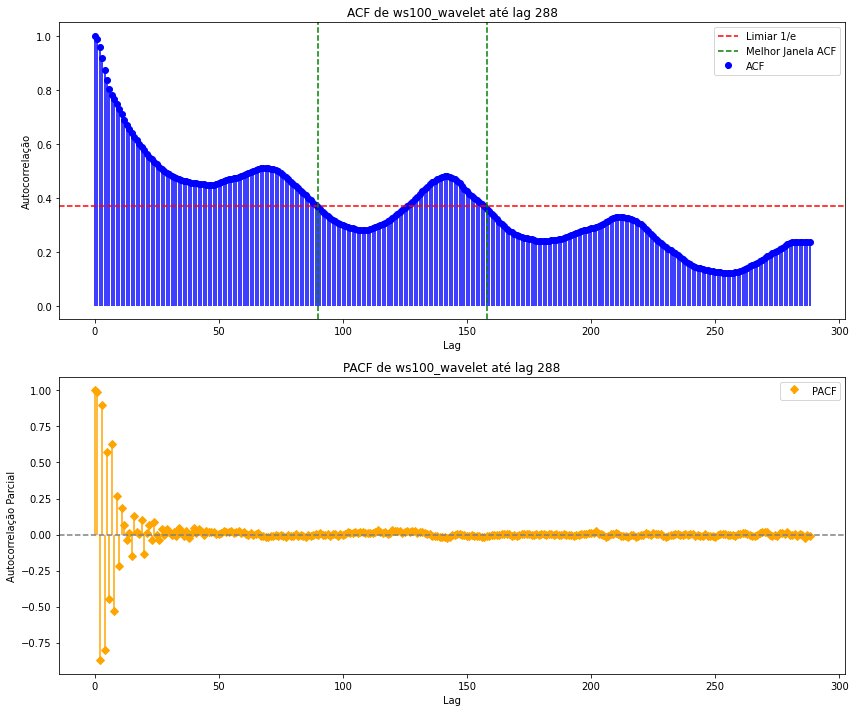

A melhor janela de previsão para wdisp40_wavelet com ACF são [ 30 165].


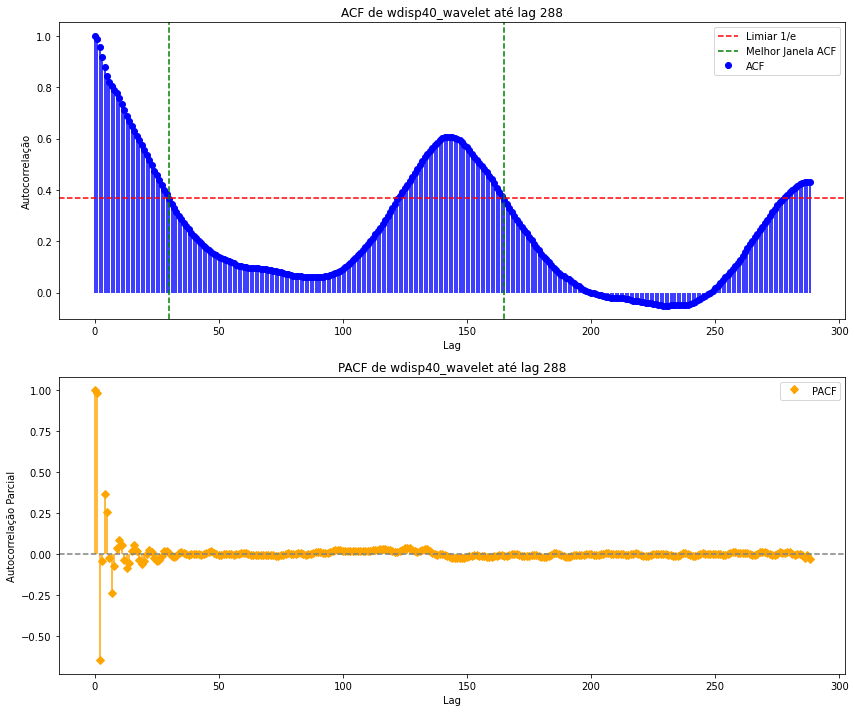

A melhor janela de previsão para vertdisp40_wavelet com ACF são [ 24 165].


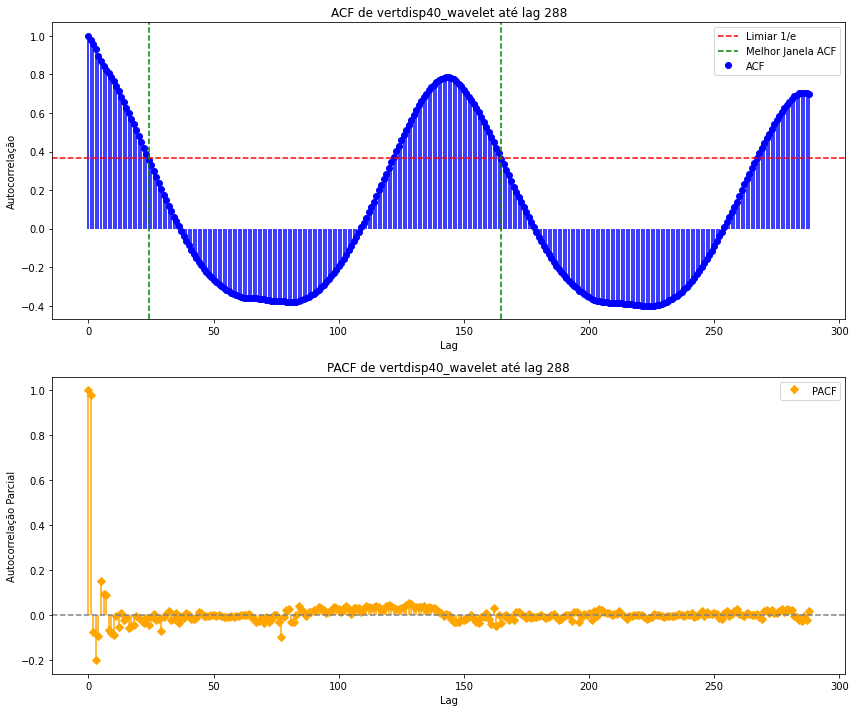

A melhor janela de previsão para wdir40_wavelet com ACF são [ 20 148].


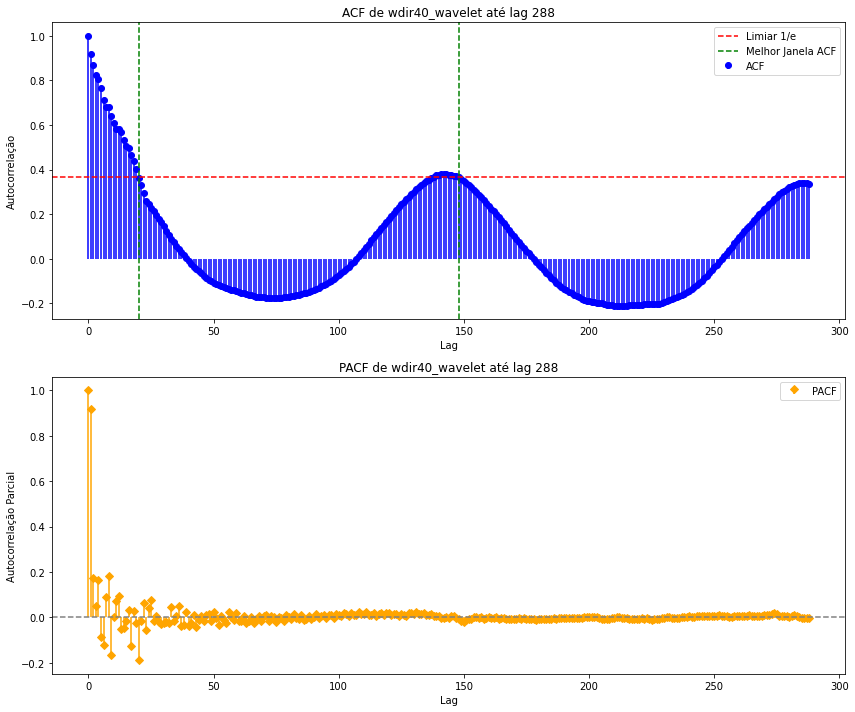

A melhor janela de previsão para cis1_wavelet com ACF são [ 25 167].


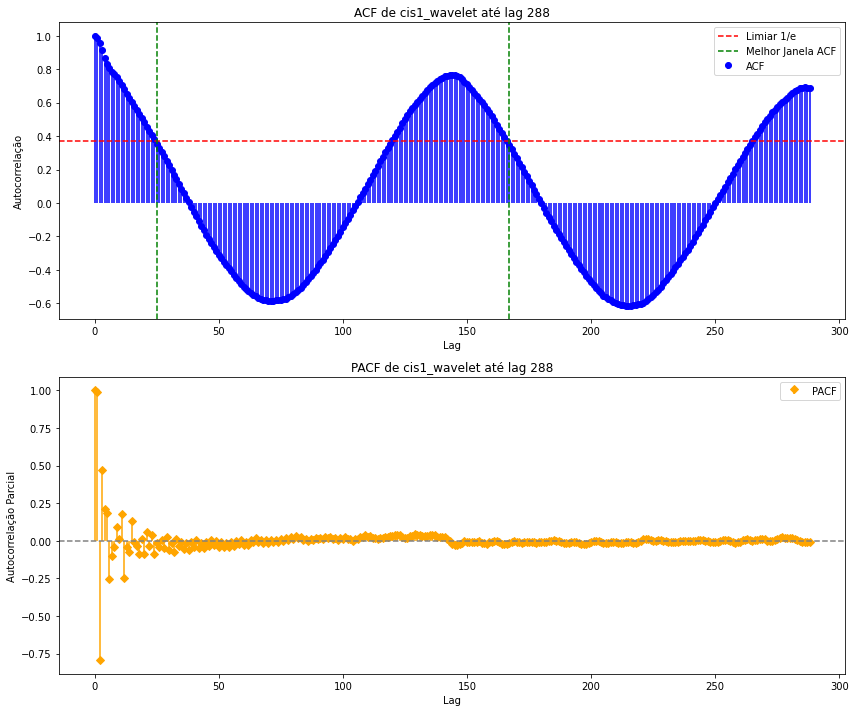

A melhor janela de previsão para humid_wavelet com ACF são [ 25 165].


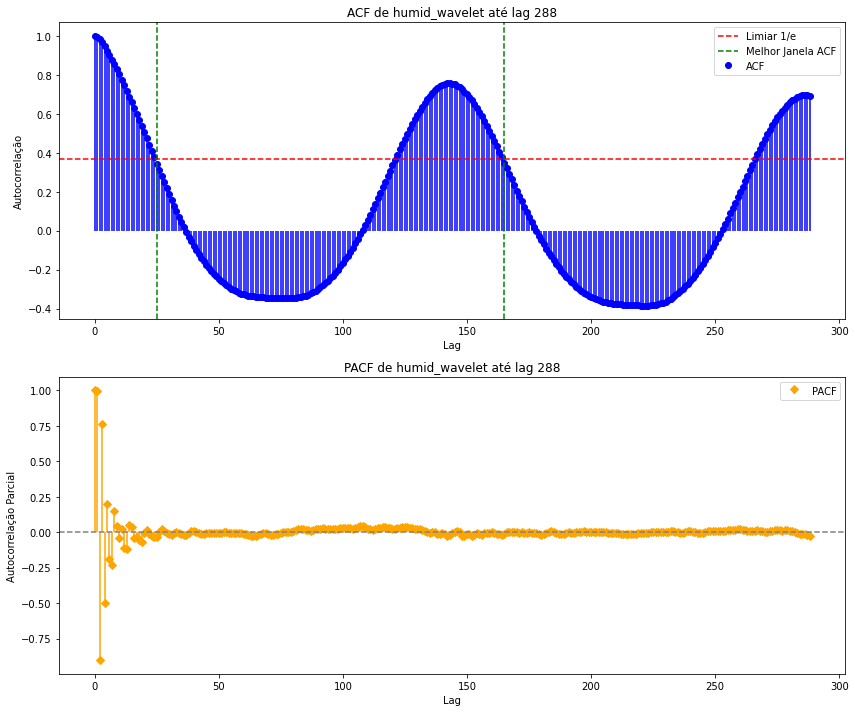

A melhor janela de previsão para temp_wavelet com ACF são [ 23 165].


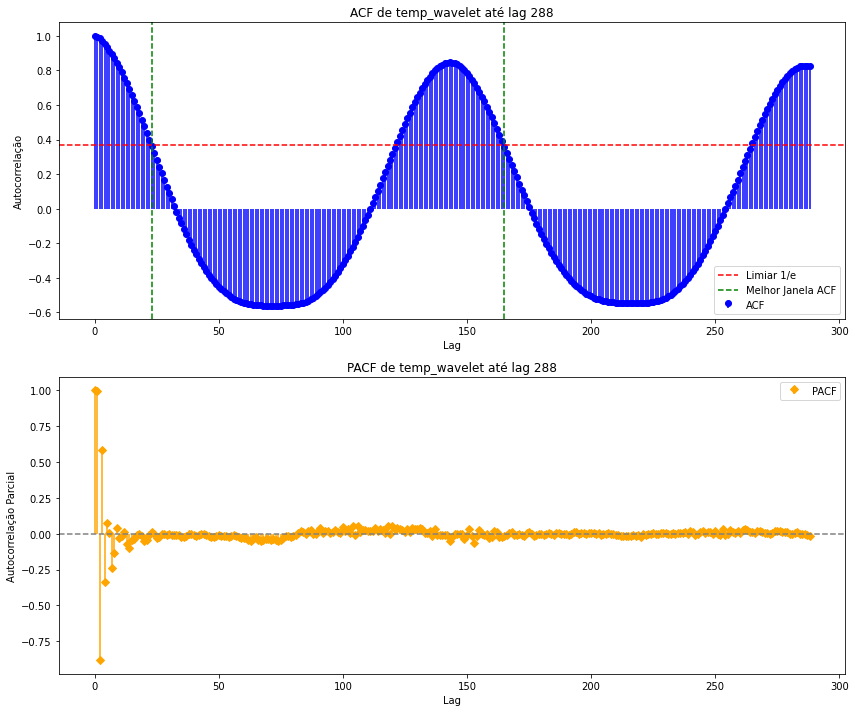

In [24]:
# Análise de autocorrelação e autocorrelação parcial

# Para cada variável, calcula e visualiza ACF e PACF
for col in variables.columns:
    signal = variables[col].dropna()
    
    # Calcula as melhores janelas de previsão usando ACF
    best_windows, acf_values = best_prediction_window(signal, max_lag=288)
    
    # Calcula a função de autocorrelação parcial (PACF)
    pacf_values = pacf(signal, nlags=288, method='ols')

    print(f"A melhor janela de previsão para {col} com ACF são {best_windows + 1}.")

    # Configuração dos subplots para visualização de ACF e PACF
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot da função de autocorrelação (ACF)
    axes[0].stem(range(len(acf_values)), acf_values, linefmt='b-', markerfmt='bo', basefmt=" ", label='ACF')
    axes[0].axhline(y=1 / np.e, color='red', linestyle='--', label='Limiar 1/e')

    # Destaca as melhores janelas de previsão no gráfico ACF
    for idx, window in enumerate(best_windows + 1):
        if idx == 0:
            axes[0].axvline(x=window, color='green', linestyle='--', label='Melhor Janela ACF')
        else:
            axes[0].axvline(x=window, color='green', linestyle='--')

    axes[0].set_title(f'ACF de {col} até lag {288}')
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelação')
    axes[0].legend()

    # Plot da função de autocorrelação parcial (PACF)
    axes[1].stem(range(len(pacf_values)), pacf_values, linefmt='orange', markerfmt='D', basefmt=" ", label='PACF')
    axes[1].axhline(y=0, color='gray', linestyle='--')
    axes[1].set_title(f'PACF de {col} até lag {288}')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Autocorrelação Parcial')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## 9. Análise de Autocorrelação

Cálculo e visualização das funções de autocorrelação (ACF) e autocorrelação parcial (PACF) para identificar padrões temporais e determinar janelas ótimas de previsão.

In [25]:
# Engenharia de features: combinação de variáveis processadas

# Combina os DataFrames de variáveis e características de rolling
variables_engineered = pd.concat([variables, rolling_features], axis=1)

# Adiciona característica cíclica: hora do dia
variables_engineered['hour'] = variables_engineered.index.hour

# Cria feature de interação: produto entre temperatura e umidade
# Esta característica representa o efeito combinado de temperatura e umidade
variables_engineered['temp_humid_product'] = (
    variables_engineered['temp_wavelet'] * 
    variables_engineered['humid_wavelet']
)

# Remove a coluna de umidade para evitar redundância
variables_engineered.drop(columns=['humid_wavelet'], inplace=True)

# Exibe as primeiras linhas do DataFrame com as novas características
variables_engineered.head()

,ws100_wavelet,wdisp40_wavelet,vertdisp40_wavelet,wdir40_wavelet,cis1_wavelet,temp_wavelet,ws100_wavelet_rolling_mean_daily,wdisp40_wavelet_rolling_mean_daily,vertdisp40_wavelet_rolling_mean_daily,wdir40_wavelet_rolling_mean_daily,cis1_wavelet_rolling_mean_daily,humid_wavelet_rolling_mean_daily,temp_wavelet_rolling_mean_daily,hour,temp_humid_product
id_datetime,,,,,,,,,,,,,,,
2021-09-16 18:00:00,8.983404,1.125007,0.541001,43.763171,0.017565,28.188888,8.983404,1.125007,0.541001,43.763171,0.017565,73.362584,28.188888,18,2068.009641
2021-09-16 18:10:00,8.849366,1.062998,0.417626,49.089948,0.023208,27.757578,8.916385,1.094003,0.479313,46.426560,0.020387,75.050151,27.973233,18,2130.053202
2021-09-16 18:19:59,8.848879,1.037261,0.392122,52.272865,0.025629,27.350217,8.893883,1.075089,0.450250,48.375328,0.022134,76.294321,27.765561,18,2154.722836
2021-09-16 18:30:00,8.952212,1.030244,0.425655,53.863347,0.025714,27.535623,8.908465,1.063877,0.444101,49.747333,0.023029,76.974263,27.708076,18,2175.702217
2021-09-16 18:39:59,9.060865,1.005019,0.435672,55.829615,0.026039,27.489673,8.938945,1.052106,0.442415,50.963789,0.023631,77.476891,27.664396,18,2185.082681


## 10. Engenharia de Features Avançada

Criação de características derivadas complexas, combinando variáveis processadas e extraindo informações cíclicas e interações entre variáveis.

In [26]:
# Análise exploratória de distribuição das variáveis (comentado para execução mais rápida)
# for col in variables_engineered.columns:
#     plt.figure(figsize=(14, 6))
#     sns.histplot(variables_engineered[col], kde=True, bins=30, color='skyblue')
#     plt.title(f'Distribuição de {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequência')
#     plt.tight_layout()
#     plt.show()

## 11. Análise de Distribuição das Variáveis

Avaliação da distribuição estatística das variáveis processadas e engenheiradas para verificar normalidade e identificar possíveis transformações necessárias.

In [27]:
# Análise de correlação cruzada (comentado para execução mais rápida)
from statsmodels.tsa.stattools import ccf

# Correlação Cruzada entre 'ws100_wavelet' e outras variáveis
target_col = 'ws100_wavelet'
# for col in variables_engineered.columns:
#     if col != target_col:
#         correlation = ccf(variables_engineered[target_col], variables_engineered[col])[:288]  # Lag até 288
#         plt.figure(figsize=(14, 6))
#         plt.stem(range(len(correlation)), correlation)
#         plt.title(f'Correlação Cruzada entre {target_col} e {col}')
#         plt.xlabel('Lag')
#         plt.ylabel('Correlação Cruzada')
#         plt.tight_layout()
#         plt.show()

## 12. Análise de Correlação Cruzada

Exame da correlação cruzada entre a velocidade do vento processada e outras variáveis para diferentes lags temporais, permitindo identificar relações defasadas entre variáveis.

In [28]:
# Preparação para modelagem preditiva

# Verificação da presença da variável alvo no conjunto de dados
if 'ws100_wavelet' not in variables_engineered.columns:
    raise ValueError("A coluna 'ws100_wavelet' não existe no DataFrame.")

# Definição das features (X) e variável alvo (y)
X = variables_engineered.drop('ws100_wavelet', axis=1)
y = variables_engineered['ws100_wavelet']

## 13. Preparação para Modelagem

Definição das features (variáveis preditoras) e da variável alvo para aplicação de algoritmos de aprendizado de máquina.

Mean Squared Error no conjunto de teste: 0.7680

Top 10 Features selecionadas pelo XGBoost:
['wdisp40_wavelet', 'wdir40_wavelet', 'ws100_wavelet_rolling_mean_daily', 'cis1_wavelet_rolling_mean_daily', 'cis1_wavelet', 'humid_wavelet_rolling_mean_daily', 'vertdisp40_wavelet', 'hour', 'wdir40_wavelet_rolling_mean_daily', 'temp_humid_product']


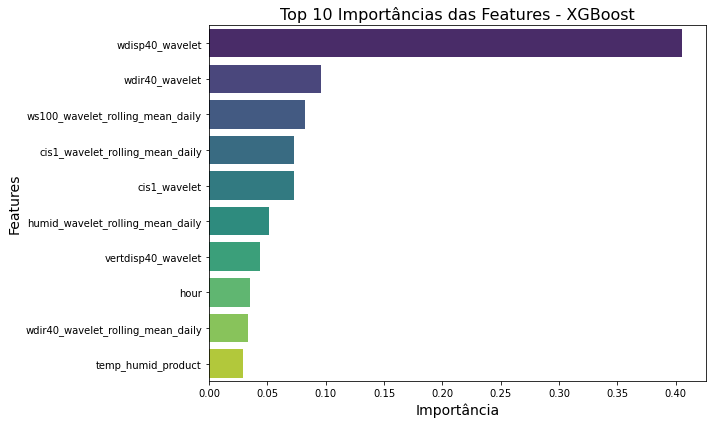

In [29]:
# Modelagem preditiva usando XGBoost para seleção de features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para modelagem
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Para seleção das top features
import xgboost as xgb

# Divisão dos dados em treino e teste (mantendo a ordem temporal)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Configuração do modelo XGBoost para regressão
model = XGBRegressor(
    objective='reg:squarederror',  # Para regressão
    n_estimators=100,              # Número de árvores
    learning_rate=0.1,             # Taxa de aprendizado
    max_depth=5,                   # Profundidade máxima das árvores
    random_state=42,
    n_jobs=-1                       # Utiliza todos os núcleos disponíveis
)

# Treinamento do modelo
model.fit(X_train, y_train)

# Avaliação do modelo no conjunto de teste
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error no conjunto de teste: {mse:.4f}")

# Extração e organização das importâncias das features
importances = model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Seleção das 10 melhores features
top_10_features = feature_importances.head(10)['Feature'].tolist()
print("\nTop 10 Features selecionadas pelo XGBoost:")
print(top_10_features)

# Visualização das importâncias das top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Importâncias das Features - XGBoost', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

## 14. Modelagem Preditiva e Seleção de Features

Treinamento de modelo preditivo utilizando XGBoost e avaliação da importância das features para selecionar as mais relevantes para a previsão da velocidade do vento.

In [30]:
# Preparação do conjunto de dados final com as features selecionadas

# Filtra o DataFrame para manter apenas as top 10 features e a variável alvo
selected_features = top_10_features + ['ws100_wavelet']
variables_selected = variables_engineered[selected_features].copy()

# Exibe as primeiras linhas do DataFrame filtrado
print("\nVariáveis selecionadas para salvamento:")
print(variables_selected.head())

# Salva o DataFrame com as features selecionadas em um arquivo CSV
# Este arquivo será utilizado pelo modelo seq2seq para treinamento
variables_selected.to_csv('processed_variables_engineered.csv', index=True)
print("\nDados processados com as 10 melhores features salvos em 'processed_variables_engineered.csv'.")


Variáveis selecionadas para salvamento:
                     wdisp40_wavelet  wdir40_wavelet   
id_datetime                                            
2021-09-16 18:00:00         1.125007       43.763171  \
2021-09-16 18:10:00         1.062998       49.089948   
2021-09-16 18:19:59         1.037261       52.272865   
2021-09-16 18:30:00         1.030244       53.863347   
2021-09-16 18:39:59         1.005019       55.829615   

                     ws100_wavelet_rolling_mean_daily   
id_datetime                                             
2021-09-16 18:00:00                          8.983404  \
2021-09-16 18:10:00                          8.916385   
2021-09-16 18:19:59                          8.893883   
2021-09-16 18:30:00                          8.908465   
2021-09-16 18:39:59                          8.938945   

                     cis1_wavelet_rolling_mean_daily  cis1_wavelet   
id_datetime                                                          
2021-09-16 18:00:00       

## 15. Preparação do Conjunto de Dados Final

Filtragem do DataFrame para manter apenas as features mais relevantes identificadas pelo modelo e exportação para uso futuro.


Features com correlação >= 1/e (em valor absoluto) com 'ws100_wavelet':

wdisp40_wavelet                          0.741979
vertdisp40_wavelet                       0.531536
ws100_wavelet_rolling_mean_daily         0.658070
wdisp40_wavelet_rolling_mean_daily       0.634587
vertdisp40_wavelet_rolling_mean_daily    0.597729
wdir40_wavelet_rolling_mean_daily        0.407940
cis1_wavelet_rolling_mean_daily          0.603199
humid_wavelet_rolling_mean_daily        -0.462558
temp_humid_product                      -0.507941
Name: ws100_wavelet, dtype: float64


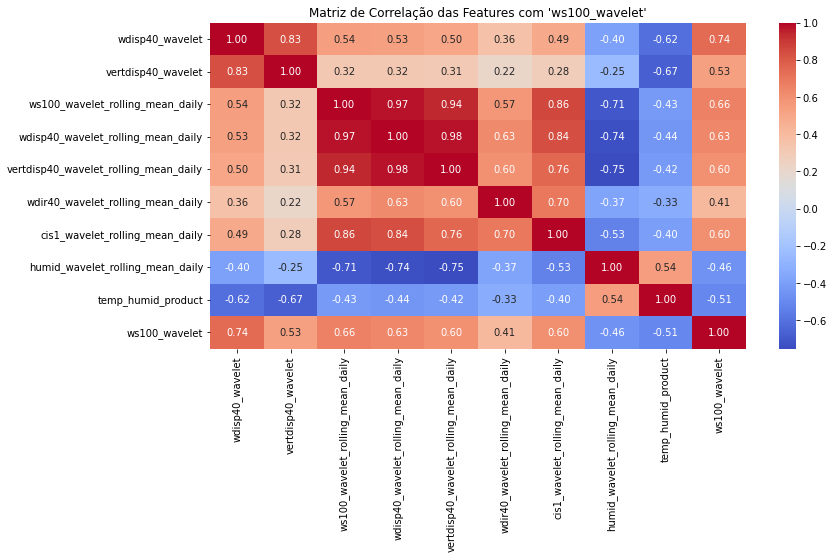

Dados processados com engenharia de features salvos em 'processed_variables_engineered.csv'.


In [31]:
# Análise final: correlação entre as variáveis processadas

# Cálculo da matriz de correlação
corr_matrix = variables_engineered.corr()

# Verifica se a variável alvo está presente na matriz de correlação
if 'ws100_wavelet' in corr_matrix.columns:
    # Seleciona correlações com a variável alvo
    ws100_corr = corr_matrix['ws100_wavelet']
    
    # Filtra features com correlação significativa (>= 1/e em valor absoluto)
    high_corr_features = ws100_corr[corr_matrix['ws100_wavelet'].abs() >= 1/np.e].drop('ws100_wavelet', errors='ignore')
else:
    raise ValueError("A coluna 'ws100_wavelet' não existe na matriz de correlação.")

# Exibe as features com correlação significativa
print("\nFeatures com correlação >= 1/e (em valor absoluto) com 'ws100_wavelet':\n")
print(high_corr_features)

# Matriz de correlação das features selecionadas
high_corr_df = variables_engineered[high_corr_features.index.tolist() + ['ws100_wavelet']].corr()

# Visualização da matriz de correlação
plt.figure(figsize=(12, 6))
sns.heatmap(high_corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Features com 'ws100_wavelet'")
plt.show()

# Atualiza o DataFrame final para incluir apenas features com alta correlação
variables_engineered = variables_engineered[high_corr_features.index.tolist() + ['ws100_wavelet']].copy()

# Salva o conjunto de dados final com as features de alta correlação
variables_engineered.to_csv('processed_variables_engineered.csv', index=True)
print("Dados processados com engenharia de features salvos em 'processed_variables_engineered.csv'.")

## 16. Análise Final de Correlação

Avaliação das correlações entre as variáveis processadas e a variável alvo, selecionando apenas as features com correlação significativa para o conjunto de dados final.

## 17. Conclusões

A análise realizada neste notebook demonstra a eficácia das transformadas wavelet para o processamento de sinais temporais relacionados à velocidade do vento. O denoising wavelet permitiu reduzir o ruído presente nos dados e destacar tendências subjacentes, melhorando significativamente a qualidade das features. 

A aplicação de técnicas de engenharia de features, como médias móveis e extração de características cíclicas, combinada com a análise de correlação e importância de variáveis, possibilitou identificar um conjunto reduzido de variáveis altamente preditivas para a velocidade do vento a 100m de altura.

As principais descobertas incluem:

1. A identificação de variáveis com alta correlação com a velocidade do vento a 100m
2. A eficiência do denoising wavelet para redução de ruído nos sinais
3. A determinação de lags temporais significativos através da análise de AMI e ACF
4. A seleção das 10 melhores features preditivas através do modelo XGBoost

Os dados processados e as features selecionadas foram salvos em um arquivo CSV para uso em modelagens futuras, como modelos de sequência temporal (seq2seq) ou outras arquiteturas de aprendizado profundo para previsão do perfil de vento.